# EDA version 2 and Topic Modeling

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt
from datetime import date
from dateManipulation import DateManipulation
import os
import seaborn as sns

In [2]:
# !pip install wordcloud

In [3]:
#Reading data
ad_data = pd.read_csv("../data/facebook_ad_Senate_v2.csv", dtype='object')
print("%s Rows with %s colummns imported"%(ad_data.shape[0],ad_data.shape[1]))

1002439 Rows with 30 colummns imported


In [4]:
ad_data.columns

Index(['id', 'state', 'candidate', 'party', 'competitiveness', 'status',
       'vote_results', 'vote_pct', 'ad_start_time', 'ad_stop_time', 'page_id',
       'page_name', 'funding_entity', 'ad_body_text', 'ad_link_caption',
       'ad_link_description', 'ad_link_title', 'spend_lower', 'spend_upper',
       'impressions_lower', 'impressions_upper', 'male', 'female', 'age18_24',
       'age25_34', 'age35_44', 'age45_54', 'age55_64', 'age65plus',
       'ad_snapshot_url'],
      dtype='object')

In [5]:
ad_data.head()

id          state         candidate       party  \
0  100856024130484        Montana        Jon Tester  Democratic   
1  101997030677488  Massachusetts  Elizabeth Warren  Democratic   
2  102667617288131        Arizona    Kyrsten Sinema  Democratic   
3  103110553961082          Texas     Beto O'Rourke  Democratic   
4  103563293917837  Massachusetts  Elizabeth Warren  Democratic   

    competitiveness      status vote_results vote_pct ad_start_time  \
0            Tossup   Incumbent          Won     0.50     5/15/2018   
1  Solid Democratic   Incumbent          Won     0.60     5/20/2018   
2            Tossup        Open          Won     0.50     5/22/2018   
3            Tossup  Challenger         Lost     0.48     9/27/2018   
4  Solid Democratic   Incumbent          Won     0.60     9/28/2018   

  ad_stop_time  ... impressions_upper  male female age18_24 age25_34 age35_44  \
0    5/17/2018  ...             14999  0.40   0.60     0.06     0.16     0.18   
1    5/21/2018  ...              1999  1.00   0.00     0.00     0.00     0.00   
2    5/31/2018  ...               999  0.35   0.64     0.07     0.10     0.12   
3    9/27/2018  ...              1999  0.39   0.61     0.74     0.25     0.00   
4    9/30/2018  ...              5999  0.24   0.75     0.00     0.00     0.00   

  age45_54 age55_64 age65plus  \
0     0.17     0.21      0.22   
1     0.00     1.00      0.00   
2     0.17     0.27      0.25   
3     0.00     0.00      0.00   
4     0.19     0.43      0.37   

                                     ad_snapshot_url  
0  https://www.facebook.com/ads/archive/render_ad...  
1  https://www.facebook.com/ads/archive/render_ad...  
2  https://www.facebook.com/ads/archive/render_ad...  
3  https://www.facebook.com/ads/archive/render_ad...  
4  https://www.facebook.com/ads/archive/render_ad...  

[5 rows x 30 columns]

In [6]:
#dropping rows with empty candidate name
ad_data.dropna(subset=['candidate'], inplace=True)
print("%s rows remaning after dropping 'nan' candidates"%(ad_data.shape[0]))

48087 rows remaning after dropping 'nan' candidates


In [7]:
ad_data[['funding_entity','ad_body_text','ad_link_caption','ad_link_description','ad_link_title','impressions_upper']].isna().sum()
# ad_data.isna().sum()

funding_entity           456
ad_body_text             309
ad_link_caption         8984
ad_link_description    13373
ad_link_title           9041
impressions_upper        106
dtype: int64

### Calculating ad runtime

In [8]:
# Substituting missing end dates with 2018 election date (2018-11-06)
# ad_data.ad_stop_time = ad_data['ad_stop_time'].fillna('2018-11-06T00:00:00+0000')
# DM = DateManipulation()

#Calculating runtime hours and days in dataframe

# ad_data['runtime_hours'] = ad_data.apply(lambda row: DM.duration_between(row.ad_start_time,row.ad_stop_time), axis = 1) 
# ad_data['runtime_days'] = ad_data.apply(lambda row: DM.duration_between(row.ad_start_time,row.ad_stop_time, "days"), axis = 1) 

#Creating date columne from datetime
# ad_data['ad_start_time_datetime'] = ad_data.ad_start_time.apply(DM.convert_to_date)
# ad_data['ad_stop_time_datetime'] = ad_data.ad_stop_time.apply(DM.convert_to_date)

In [9]:
def duration_calc(f_date, l_date):
    f_date = [int(x) for x in f_date.split("/")]
    l_date = [int(x) for x in l_date.split("/")]
    delta = date(l_date[2],l_date[0],l_date[1]) - date(f_date[2],f_date[0],f_date[1])
    return delta.days

In [10]:
ad_data['runtime_days'] = ad_data.apply(lambda row: duration_calc(row.ad_start_time,row.ad_stop_time)+1, axis = 1)

In [11]:
ad_data[['ad_start_time','ad_stop_time','runtime_days']]

ad_start_time ad_stop_time  runtime_days
0         5/15/2018    5/17/2018             3
1         5/20/2018    5/21/2018             2
2         5/22/2018    5/31/2018            10
3         9/27/2018    9/27/2018             1
4         9/28/2018    9/30/2018             3
...             ...          ...           ...
48082    10/19/2018   10/20/2018             2
48083     11/3/2018    11/6/2018             4
48084     9/28/2018    9/28/2018             1
48085     9/25/2018    9/30/2018             6
48086    10/30/2018    11/2/2018             4

[48087 rows x 3 columns]

In [12]:
#ad_data = ad_data.drop(columns=["ad_start_time","ad_stop_time"])

In [13]:
#number of unique Ads
print("\nNumber of Unique Ads text : %s\n"%ad_data.ad_body_text.nunique())


Number of Unique Ads text : 7068



In [14]:
#number of States

print("\nNumber of States for which data is available : %s\n"%ad_data.state.nunique())


Number of States for which data is available : 35



In [15]:
#Winners and losing candidate count
ad_data.groupby(["vote_results"]).candidate.nunique()

vote_results
Lost    36
Won     36
Name: candidate, dtype: int64

In [16]:
# ad_data[ad_data["vote_results"]=="Lost"].candidate.unique()
# ad_data[ad_data["vote_results"]=="Won"].candidate.unique()

In [17]:
plt.style.use('ggplot')
# plt.style.use('seaborn-poster')

In [18]:
def summarise_df(df,columns=[],summary_field= None, summary_computation="mean",topn=10,sort_asce=True):
    #summary_computation : mean, sum, count, unique
    if not int(topn):
        return "INVALID value of top N"
    if summary_field not in columns and summary_field is not None:
        columns.append(summary_field)
        data = df[columns]
        
        if summary_computation == "sum":
            data = data.groupby(columns[:-1])[summary_field].sum().sort_values(ascending=sort_asce).head(topn)
        elif summary_computation == "count":
            data = data.groupby(columns[:-1])[summary_field].count().sort_values(ascending=sort_asce).head(topn)
        elif summary_computation == "unique":
            data = data.groupby(columns[:-1])[summary_field].nunique().sort_values(ascending=sort_asce).head(topn)  
        else:
            data = data.groupby(columns[:-1])[summary_field].mean().sort_values(ascending=sort_asce).head(topn)  
        
        data = pd.DataFrame(data)
        if len(columns) <= 2:
            data[columns[0]] = [data.index[row] for row in range(len(data))]
        else:    
            for i in range(len(columns)-1):
                data[columns[i]] = [data.index[row][i] for row in range(len(data))]

        data["index"] = [x for x in range(len(data))]
        data.set_index('index', inplace= True)
    else:
        data = df[columns]
    return data    

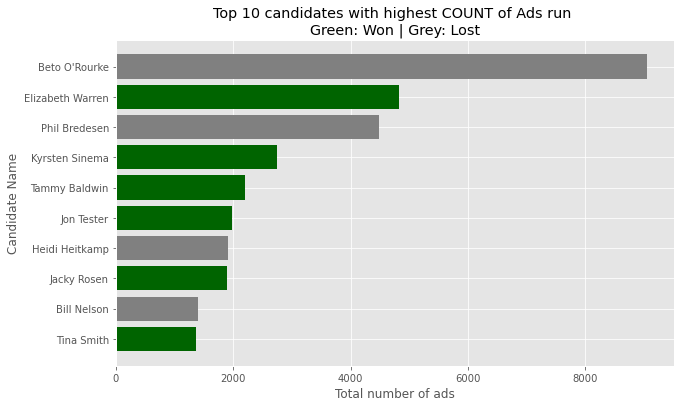

In [19]:
# ad_data.groupby(['candidate','vote_results']).runtime_days.count().sort_values(ascending=False).head(10).plot.barh()
plt.figure(figsize=(10,6))
tempdf = summarise_df(ad_data,['candidate','vote_results'],"runtime_days","count",10,False).sort_values(by="runtime_days")
plt.barh(tempdf.candidate,tempdf.runtime_days, color = ['darkgreen' if val == "Won" else 'grey' for val in list(tempdf.vote_results)])
plt.title("Top 10 candidates with highest COUNT of Ads run \nGreen: Won | Grey: Lost")
plt.xlabel("Total number of ads")
plt.ylabel("Candidate Name")
plt.show()

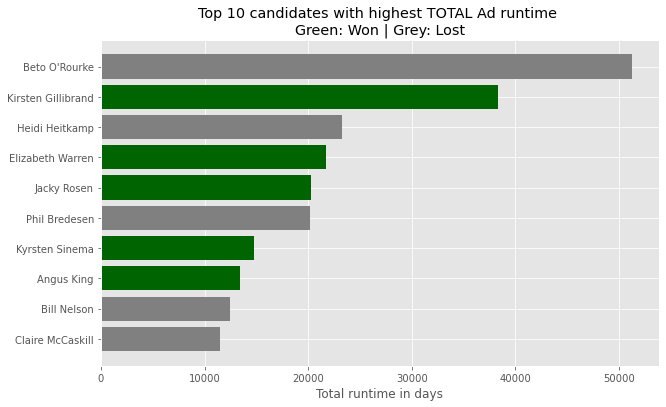

In [20]:
# Top 10 candidates is highest OVERALL ad runtime (in days)
# Data might not reflect the correct insights as the ads might have been running simultaneously
# ad_data.groupby(['candidate','vote_results']).runtime_days.sum().sort_values(ascending=False).head(10).plot.barh()
plt.figure(figsize=(10,6))
tempdf = summarise_df(ad_data,['candidate','vote_results'],"runtime_days","sum",10,False).sort_values(by="runtime_days")
plt.barh(tempdf.candidate,tempdf.runtime_days, color = ['darkgreen' if val == "Won" else 'grey' for val in list(tempdf.vote_results)])
plt.title("Top 10 candidates with highest TOTAL Ad runtime \nGreen: Won | Grey: Lost")
plt.xlabel("Total runtime in days")
plt.show()

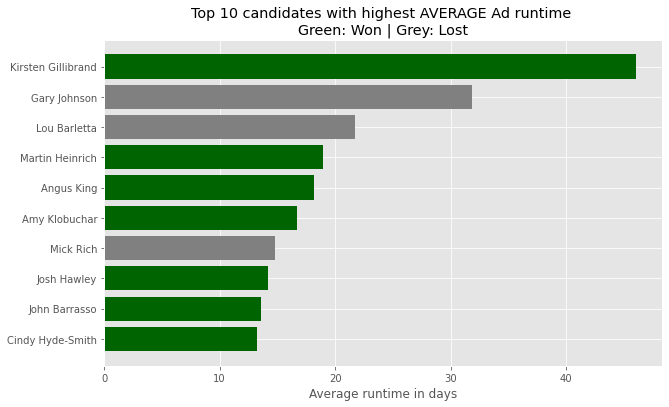

In [21]:
# Top 10 candidates is highest AVERAGE ad runtime (in hours)
# ad_data.groupby(['candidate','vote_results']).runtime_days.mean().sort_values(ascending=False).head(10).plot.barh()
plt.figure(figsize=(10,6))
tempdf = summarise_df(ad_data,['candidate','vote_results'],"runtime_days","mean",10,False).sort_values(by="runtime_days")
plt.barh(tempdf.candidate,tempdf.runtime_days, color = ['darkgreen' if val == "Won" else 'grey' for val in list(tempdf.vote_results)])
plt.title("Top 10 candidates with highest AVERAGE Ad runtime \nGreen: Won | Grey: Lost")
plt.xlabel("Average runtime in days")
plt.show()

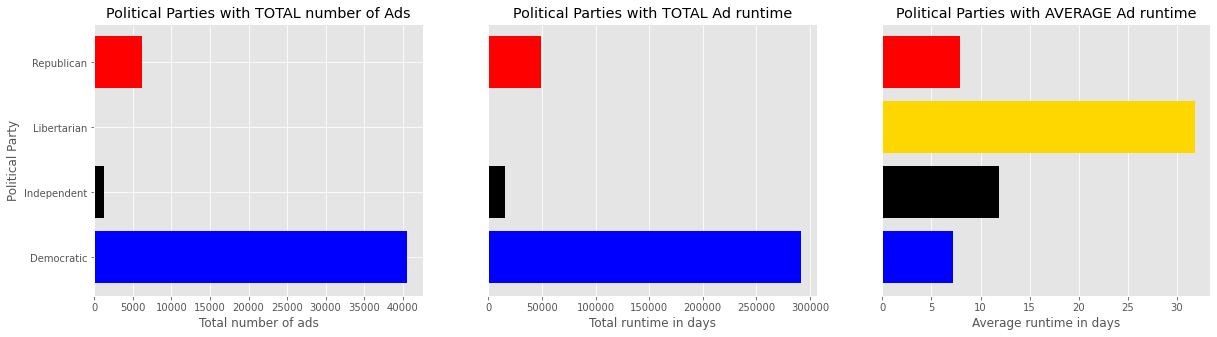

In [22]:
# Average ad runtime (in hours) by political parties
fig, axs = plt.subplots(1,3, figsize=(20,5))
tempdf = summarise_df(ad_data,['party'],"runtime_days","count",10,False).sort_values("party")
# ad_data.groupby('party').runtime_days.count().plot.barh(ax=axs[0])
axs[0].barh(tempdf.party, tempdf.runtime_days, color =["blue","black","gold","red"])
axs[0].set_title("Political Parties with TOTAL number of Ads")
axs[0].set_xlabel("Total number of ads")
axs[0].set_ylabel("Political Party")

tempdf = summarise_df(ad_data,['party'],"runtime_days","sum",10,False).sort_values("party")
# ad_data.groupby('party').runtime_days.sum().plot.barh(ax=axs[1])
axs[1].barh(tempdf.party, tempdf.runtime_days, color =["blue","black","gold","red"])
axs[1].set_title("Political Parties with TOTAL Ad runtime")
axs[1].set_xlabel("Total runtime in days")
axs[1].get_yaxis().set_visible(False)

tempdf = summarise_df(ad_data,['party'],"runtime_days","mean",10,False).sort_values("party")
# ad_data.groupby('party').runtime_days.mean().plot.barh(ax=axs[2])
axs[2].barh(tempdf.party, tempdf.runtime_days, color =["blue","black","gold","red"])
axs[2].set_title("Political Parties with AVERAGE Ad runtime")
axs[2].set_xlabel("Average runtime in days")
axs[2].get_yaxis().set_visible(False)
plt.show()

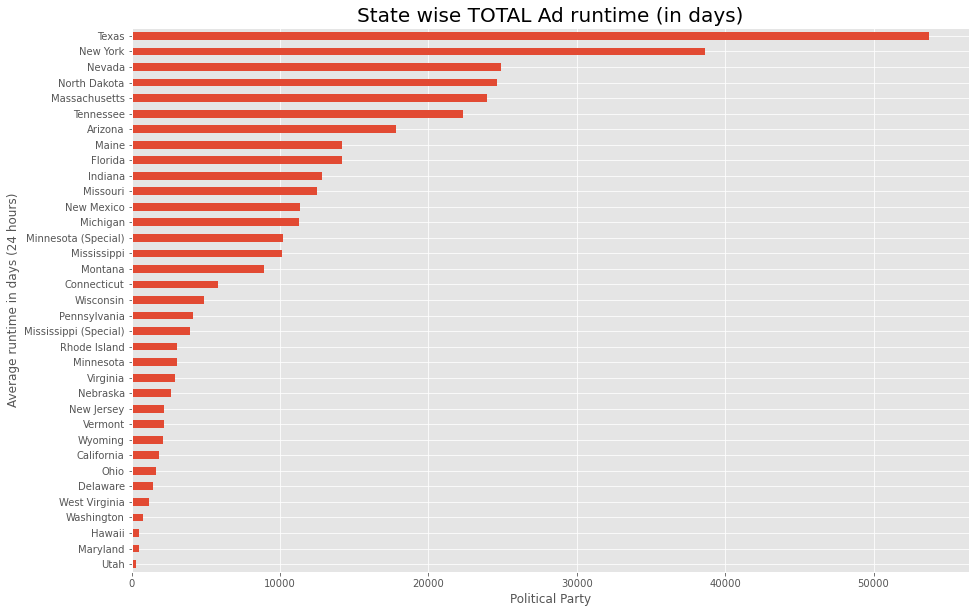

In [23]:
ad_data.groupby('state').runtime_days.sum().sort_values().plot.barh(figsize=(15,10))
plt.title("State wise TOTAL Ad runtime (in days)" ,size = 20)
plt.ylabel("Average runtime in days (24 hours)")
plt.xlabel("Political Party")
plt.show()

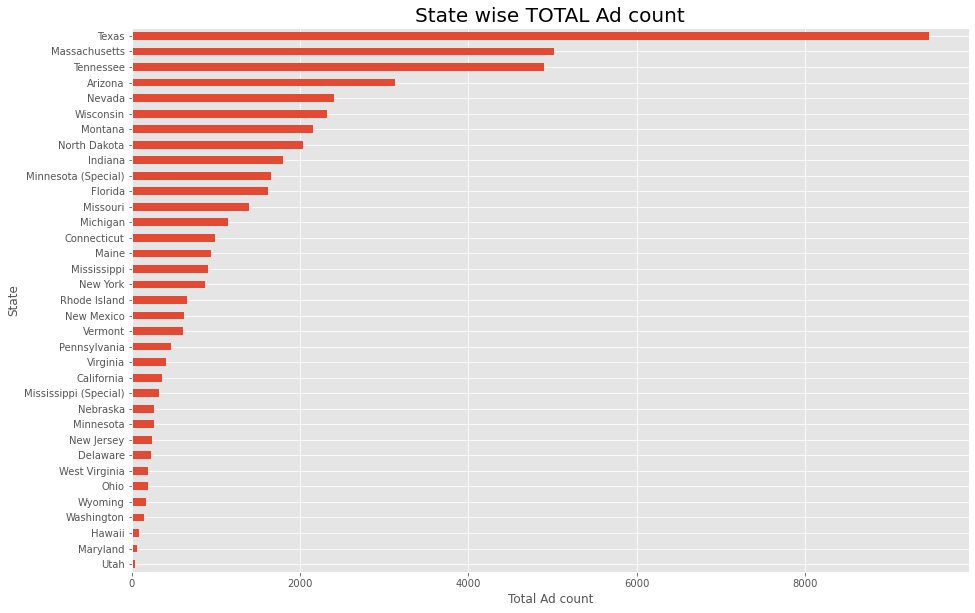

In [24]:
ad_data.groupby('state').runtime_days.count().sort_values().plot.barh(figsize=(15,10))
plt.title("State wise TOTAL Ad count", size=20)
plt.ylabel("State")
plt.xlabel("Total Ad count")
plt.show()

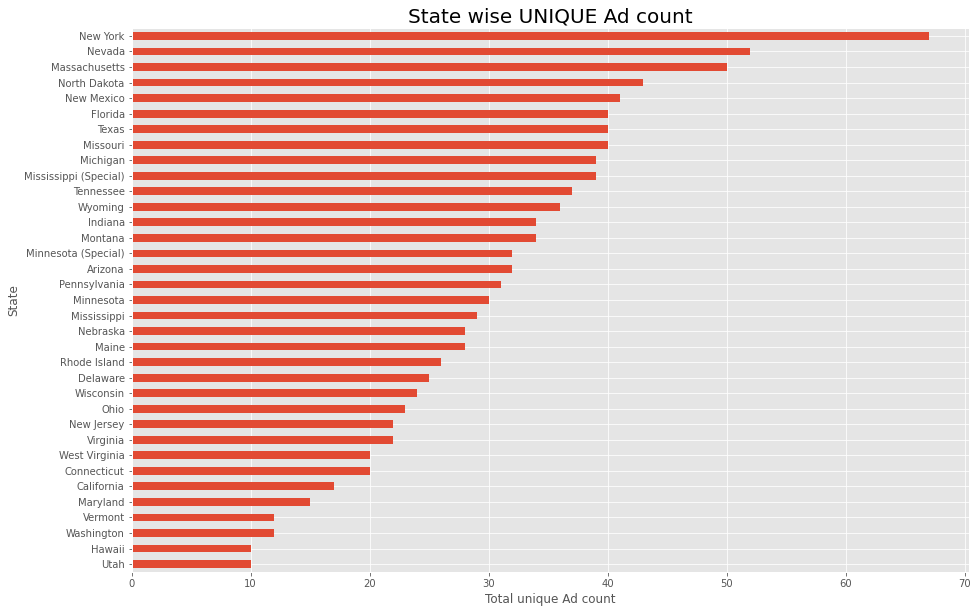

In [25]:
ad_data.groupby('state').runtime_days.nunique().sort_values().plot.barh(figsize=(15,10))
plt.title("State wise UNIQUE Ad count", size=20)
plt.ylabel("State")
plt.xlabel("Total unique Ad count")
plt.show()

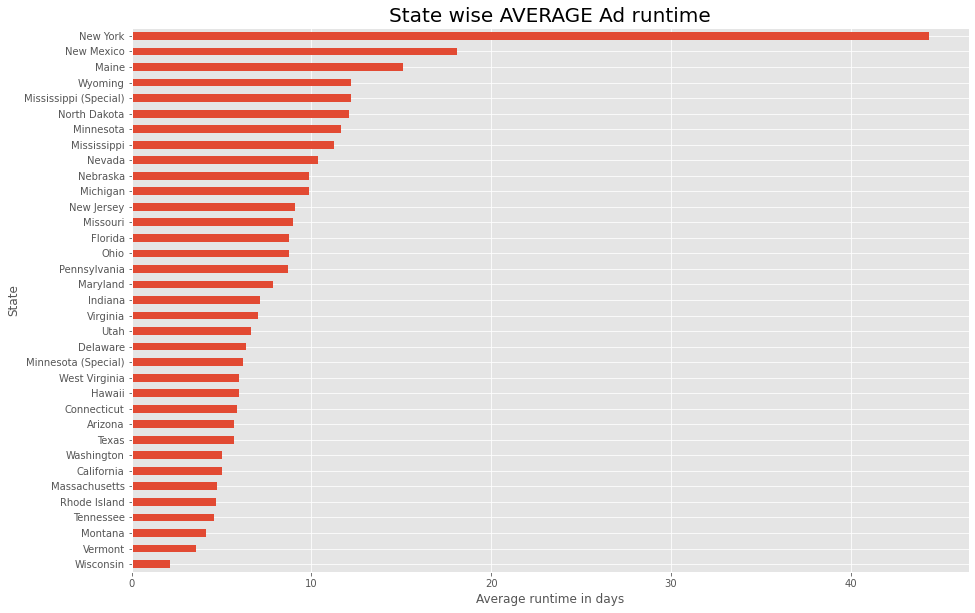

In [26]:
ad_data.groupby('state').runtime_days.mean().sort_values().plot.barh(figsize=(15,10))
plt.title("State wise AVERAGE Ad runtime", size=20)
plt.ylabel("State")
plt.xlabel("Average runtime in days")
plt.show()

****
# Topic Modeling

## (1) Using LDA 

### Separating text data for topic modeling

In [32]:
text_data = ad_data.ad_body_text.unique()

In [33]:
text_data = pd.DataFrame(text_data, columns=["ad_text"])
text_data['index'] = text_data.index 
text_data.dropna(inplace=True)
text_data.reset_index(drop=True, inplace=True)

In [34]:
text_data.head()

ad_text  index
0  I’m leading a bipartisan coalition of business...      0
1  The bank lobbyists have a Dodd-Frank rollback ...      1
2  Do you think politicians should be able to mak...      2
3  Come meet Congressman Beto O'Rourke at UT Arli...      3
4  Brett Kavanaugh has shown us that it’s more im...      4

## Data Preprocessing

* **Tokenization:** Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
Words that have fewer than 3 characters are removed.
* **Stopwords:** All stopwords are removed.
* **Lemmatization:** Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
* **Stemming:** Words are stemmed — words are reduced to their root form.

In [38]:
# !pip install gensim

In [39]:
# !pip install nltk
import nltk
# nltk.download('wordnet')

In [44]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
import re

In [90]:
#Lemmatizing function
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    wnl = WordNetLemmatizer()
    return text
#     return stemmer.stem(text)

#     return stemmer.stem(wnl.lemmatize(text, pos='v'))

In [91]:
#Custom list of STOPWORDS:

state_name_list = [s.split() for s in ad_data.state.unique()]
candidate_name_list = [name.split() for name in ad_data.candidate.unique()]

cust_StopWords = ['link','donald','trump','senator','senate','november']

for names in candidate_name_list:
    for name in names:
        cust_StopWords.append(name.lower())
        
for states in state_name_list:
    for state in states:
        cust_StopWords.append(state.lower()) 


In [92]:
# Pre-processing function

def preprocess(text):
    result = []
    text = re.sub(r'\bhttp[s]?:[\w\W]+\b','link',text)
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and \
        token not in cust_StopWords and len(token) > 3  and not token.isdigit():
            result.append(lemmatize_stemming(token))
    return result

In [93]:
doc_sample = text_data[text_data['index'] == 59].values[0][0]

words = []
# doc_sample = re.findall(r'\bhttp:[\w\W]+\b','',doc_sample)

for word in doc_sample.split(' '):
    words.append(word)
    
print('original document: %s'%words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: ['Tennesseans', 'have', 'a', 'clear', 'choice', 'in', 'this', 'election.', 'If', 'you’re', 'tired', 'of', 'Washington’s', 'shouting,', 'find', 'your', 'early', 'voting', 'location', 'and', 'make', 'a', 'plan', 'to', 'vote', 'right', 'now.']


 tokenized and lemmatized document: 
['tennesseans', 'clear', 'choice', 'election', 'tired', 'shouting', 'early', 'voting', 'location', 'plan', 'vote', 'right']


In [94]:
processed_docs = text_data['ad_text'].map(preprocess)
processed_docs[:10]

0    [leading, bipartisan, coalition, business, com...
1    [bank, lobbyists, dodd, frank, rollback, pass,...
2    [think, politicians, able, health, care, choic...
3    [come, meet, congressman, rourke, arlington, r...
4    [brett, kavanaugh, shown, important, democrats...
5    [breaking, race, moved, lean, republican, toss...
6    [sure, ready, vote, election, days, left, elec...
7    [brett, kavanaugh, testimony, thing, clear, be...
8    [tennesseans, want, proven, track, record, get...
9    [republican, control, turn, ounce, anger, kava...
Name: ad_text, dtype: object

In [95]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 bipartisan
1 business
2 coalition
3 community
4 companies
5 congress
6 forward
7 gateway
8 given
9 hasn
10 help


In [96]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [97]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(48, 1),
 (55, 1),
 (106, 1),
 (258, 1),
 (623, 1),
 (671, 1),
 (718, 1),
 (804, 1),
 (818, 1),
 (1051, 1),
 (1247, 1)]

In [98]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 48 ("come") appears 1 time.
Word 55 ("join") appears 1 time.
Word 106 ("family") appears 1 time.
Word 258 ("polls") appears 1 time.
Word 623 ("walk") appears 1 time.
Word 671 ("county") appears 1 time.
Word 718 ("free") appears 1 time.
Word 804 ("celebrate") appears 1 time.
Word 818 ("event") appears 1 time.
Word 1051 ("food") appears 1 time.
Word 1247 ("games") appears 1 time.


In [99]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.23146072173291518),
 (1, 0.19980838207682014),
 (2, 0.16599306587441107),
 (3, 0.20777623747653176),
 (4, 0.17801661392853085),
 (5, 0.15881224316322468),
 (6, 0.25482433892239015),
 (7, 0.27443014168560254),
 (8, 0.09358877134054894),
 (9, 0.2697897615084266),
 (10, 0.2324368652846288),
 (11, 0.20835945404845405),
 (12, 0.22864985470871454),
 (13, 0.22034826445640288),
 (14, 0.17228523974179846),
 (15, 0.2174034586598384),
 (16, 0.23765191892273602),
 (17, 0.2581375413708796),
 (18, 0.27443014168560254),
 (19, 0.16437416953733344),
 (20, 0.22034826445640288),
 (21, 0.08862971328109392)]


In [100]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.014*"election" + 0.014*"president" + 0.013*"join" + 0.012*"campaign" + 0.012*"fighting" + 0.009*"support" + 0.009*"today" + 0.009*"like" + 0.008*"help" + 0.008*"team"
Topic: 1 
Words: 0.015*"today" + 0.013*"campaign" + 0.011*"state" + 0.010*"families" + 0.010*"support" + 0.009*"country" + 0.009*"join" + 0.009*"jobs" + 0.009*"need" + 0.009*"know"
Topic: 2 
Words: 0.021*"join" + 0.018*"vote" + 0.018*"campaign" + 0.014*"rally" + 0.013*"election" + 0.012*"president" + 0.012*"meet" + 0.012*"work" + 0.012*"supporters" + 0.011*"elect"
Topic: 3 
Words: 0.014*"fight" + 0.014*"help" + 0.014*"care" + 0.014*"need" + 0.011*"health" + 0.009*"race" + 0.009*"today" + 0.009*"needs" + 0.009*"support" + 0.009*"people"
Topic: 4 
Words: 0.019*"campaign" + 0.017*"join" + 0.013*"vote" + 0.012*"today" + 0.010*"help" + 0.009*"support" + 0.008*"time" + 0.007*"election" + 0.007*"america" + 0.007*"free"
Topic: 5 
Words: 0.040*"vote" + 0.016*"sign" + 0.014*"election" + 0.014*"come" + 0.012*"help

In [101]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"rsvp" + 0.010*"free" + 0.010*"join" + 0.009*"tickets" + 0.008*"invited" + 0.006*"friday" + 0.006*"vote" + 0.006*"deserve" + 0.005*"sign" + 0.005*"come"
Topic: 1 Word: 0.010*"join" + 0.008*"election" + 0.007*"campaign" + 0.007*"town" + 0.007*"vote" + 0.006*"hall" + 0.006*"rourke" + 0.006*"today" + 0.006*"para" + 0.006*"meet"
Topic: 2 Word: 0.012*"vote" + 0.009*"president" + 0.007*"county" + 0.007*"help" + 0.006*"campaign" + 0.005*"need" + 0.005*"voting" + 0.005*"early" + 0.005*"work" + 0.005*"people"
Topic: 3 Word: 0.014*"para" + 0.012*"rourke" + 0.010*"sign" + 0.009*"join" + 0.007*"meet" + 0.006*"come" + 0.006*"today" + 0.006*"vote" + 0.006*"congressman" + 0.006*"talk"
Topic: 4 Word: 0.007*"fighting" + 0.007*"working" + 0.007*"county" + 0.006*"vote" + 0.006*"people" + 0.006*"help" + 0.005*"public" + 0.005*"security" + 0.005*"state" + 0.005*"care"
Topic: 5 Word: 0.007*"help" + 0.007*"campaign" + 0.007*"like" + 0.006*"today" + 0.006*"money" + 0.006*"support" + 0.006